In [48]:
import psycopg2
import pandas as pd
from contextlib import closing
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import datetime as dt
from datetime import datetime, time, timedelta
import warnings
import itertools
import statsmodels.api as sm
plt.style.use('fivethirtyeight')

In [49]:
df = pd.read_csv('../datasets/vrms.csv')
df.head()

,Unnamed: 0,date,vrms_vib1_avg
0,0,1627776068000,1.52625
1,1,1627776128000,1.51868
2,2,1627776188000,1.49958
3,3,1627776248000,1.52360
4,4,1627776308000,1.52461


In [50]:
df = df[['date', 'vrms_vib1_avg']]

In [51]:
# Замена пустых значений на ноль
df = df.fillna(0)

In [52]:
df.head()

,date,vrms_vib1_avg
0,1627776068000,1.52625
1,1627776128000,1.51868
2,1627776188000,1.49958
3,1627776248000,1.52360
4,1627776308000,1.52461


In [53]:
# Перевод даты из UNIX в формат yyyy-mm-dd hh-mm-ss
df['date'] = pd.to_datetime(df['date'], unit='ms')

In [54]:
# Установка даты и времени в качестве индекса
df = df.set_index('date')

In [55]:
df = df.sort_index()

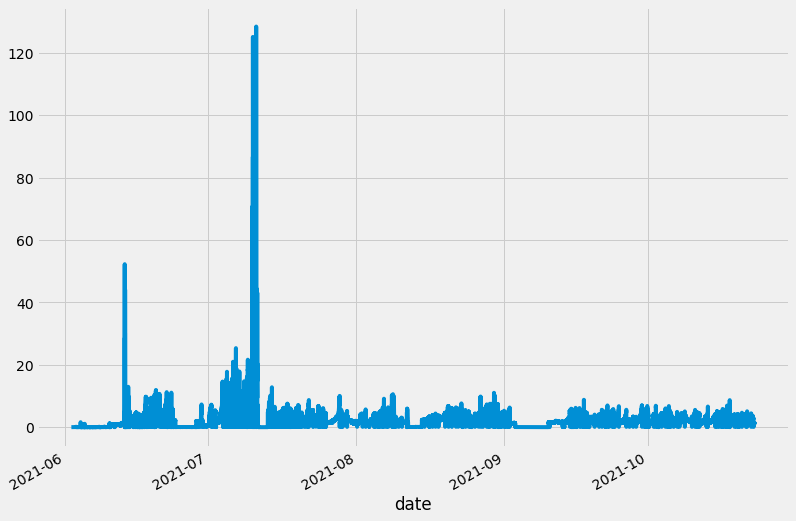

In [56]:
plt.figure(figsize=(12, 9))
df['vrms_vib1_avg'].plot();

In [57]:
# Замена пустых значений на ноль
df = df.fillna(0)

In [58]:
# Замена выбросов на 5-ти кратное среднее
df.loc[(df['vrms_vib1_avg'] > (df['vrms_vib1_avg'].mean() * 5)), 'vrms_vib1_avg'] = df['vrms_vib1_avg'].mean() * 5

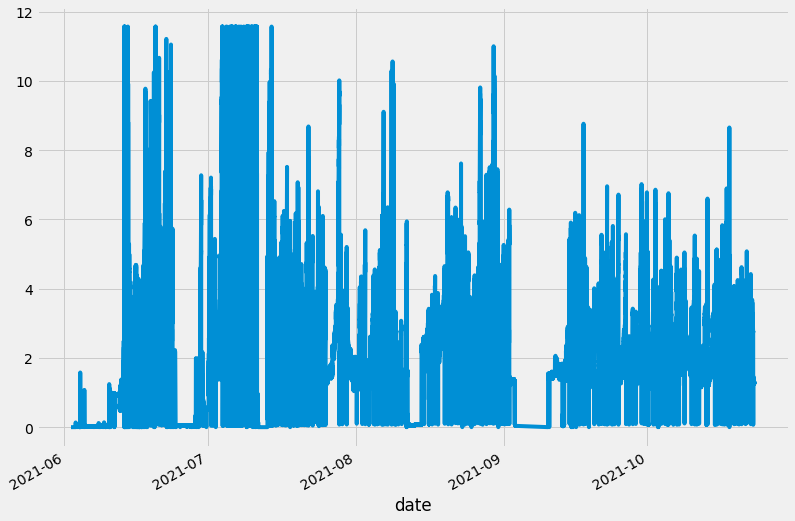

In [59]:
plt.figure(figsize=(12, 9))
df['vrms_vib1_avg'].plot();

In [60]:
# Для обучения модели возьмем период с 15 июля по 15 сентября
y = df['2021-07-15':'2021-09-15'].resample('10min').mean()

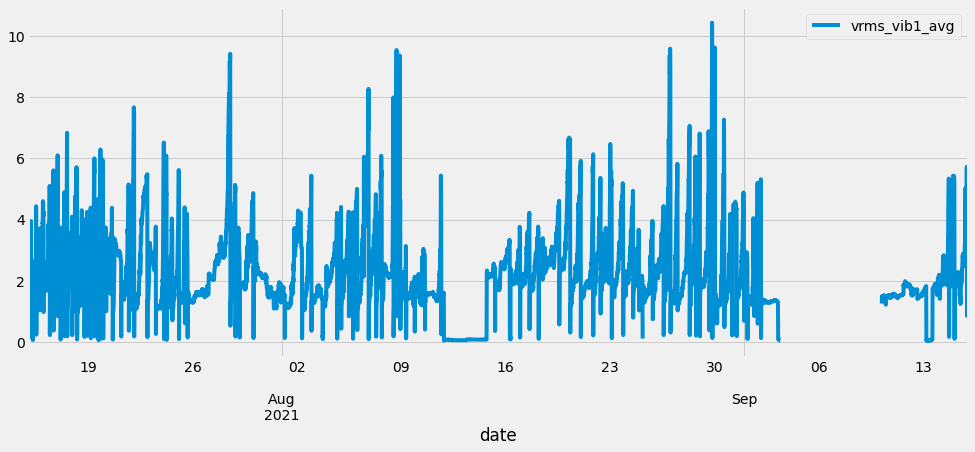

In [61]:
y.plot(figsize=(15, 6))
plt.show()

In [62]:
# Параметры для обучения модели, подобраны в другом файле
param = (15, 1, 52)

In [63]:
mod = sm.tsa.statespace.SARIMAX(y,
order=param,
enforce_stationarity=False,
enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

C:\Users\msman\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2004      0.591     -0.339      0.735      -1.359       0.958
ar.L2         -0.4501      0.488     -0.922      0.356      -1.406       0.506
ar.L3         -0.3494      0.551     -0.634      0.526      -1.429       0.731
ar.L4         -0.0858      0.610     -0.141      0.888      -1.281       1.109
ar.L5         -0.4001      0.550     -0.728      0.467      -1.477       0.677
ar.L6         -0.0625      0.513     -0.122      0.903      -1.068       0.943
ar.L7          0.1131      0.441      0.257      0.797      -0.751       0.977
ar.L8          0.0210      0.325      0.065      0.949      -0.616       0.658
ar.L9          0.1069      0.260      0.411      0.681      -0.403       0.617
ar.L10         0.1399      0.253      0.553      0.580      -0.356       0.636
ar.L11        -0.0257      0.281     -0.091      0.9

C:\Users\msman\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


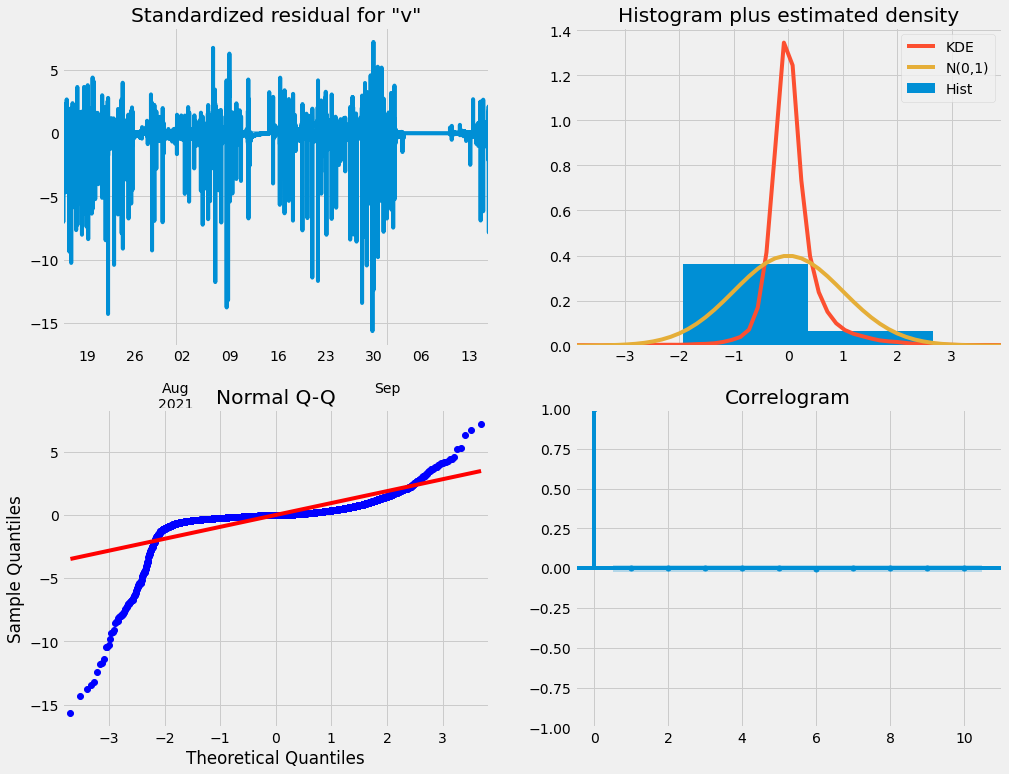

In [64]:
# Печать диагностики
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [65]:
# Прогноз на период, начиная с 2021-07-17
pred = results.get_prediction(start=pd.to_datetime('2021-09-14'), dynamic=False)
pred_ci = pred.conf_int()

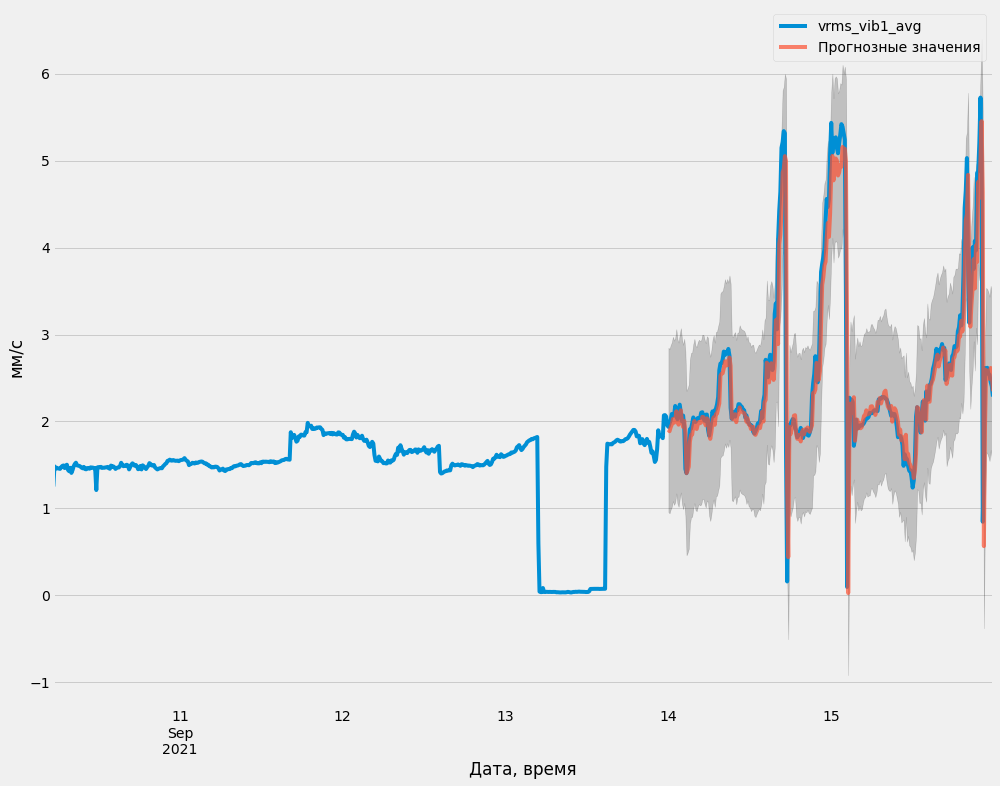

In [66]:
# Построение трендов с прогнозом
y = df['2021-09-10':'2021-09-15'].resample('10min').mean()
ax = y['2021-09-10':].plot(label='Фактические значения', figsize=(15, 12))
pred.predicted_mean.plot(ax=ax, label='Прогнозные значения', alpha=.7)
ax.fill_between(pred_ci.index,
pred_ci.iloc[:, 0],
pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Дата, время')
ax.set_ylabel('мм/с')
plt.legend()
plt.show()

In [67]:
# Расчет метрики качества RMSE
y_forecasted = pred.predicted_mean
y_truth = y['2021-09-14':] # Compute the mean square error
mse1 = mean_squared_error(y_truth, y_forecasted)**0.5
print('RMSE: {}'.format(mse1))

RMSE: 0.4508227033151345
